### The Problem
---

We are considering the differential drive robot.

State space is defined by $(x, y, \theta)$, and the dynamics can be written as follows:

$$
\begin{pmatrix}
\dot{x} \\
\dot{y} \\
\dot{\theta} \\
\end{pmatrix} = 
\begin{pmatrix}
\cos \theta & 0 \\
\sin \theta & 0 \\
0 & 1 \\
\end{pmatrix}
\begin{pmatrix}
v \\
\omega 
\end{pmatrix}
$$

Action space is defined by the rotation of the wheels:
$$
R_1, R_2, R_3, R_4
$$
Which can be transformed into $v$ and $\omega$. 

The goal is to reach a certain position
$$
\begin{pmatrix}
x_{ref} \\
y_{ref} \\
\theta_{ref} \\
\end{pmatrix}
$$

And the optimal action would be to move along the straight line connecting the start and the end. 

[Image](https://www.dropbox.com/s/fvcbrpyotr6hfkz/goal.png?dl=0)

Model predictive control (for differential drive robots)

System model:
$$
\dot{\mathbf{x}} = f_c(\mathbf{x}(t), \mathbf{u}(t))
\rightarrow 
\dot{\mathbf{x}} (k + 1) = f(\mathbf{x}(k), \mathbf{u}(k))
$$

For the Euler discretization scheme (with sampling time $\Delta T$):
$$
\begin{pmatrix}
x(k + 1) \\
y(k + 1) \\
\theta (k + 1) \\
\end{pmatrix} =
\begin{pmatrix}
x(k) \\
y(k) \\
\theta (k) \\
\end{pmatrix} +
\Delta T
\begin{pmatrix}
\nu(k) \sin \theta (k)\\
\nu(k) \cos \theta (k) \\
\omega (k) \\
\end{pmatrix} 
$$

Running stage costs (here $\Vert x \Vert_A$ means $(x, Ax)$):
$$
l(\mathbf{x}, \mathbf{u}) = 
\Vert \mathbf{x}_u - \mathbf{x}_{\text{ref}} \Vert_Q^2 + 
\Vert \mathbf{u} - \mathbf{u}_{\text{ref}} \Vert_R^2
$$

Optimal control problem:
$$
\min J_{N} (\mathbf{x}_0, \mathbf{u}) = 
\sum_{k=0}^{N-1} l(\mathbf{x}(k), \mathbf{u}(k))
$$

Subject to constraints:
$$
\mathbf{x}_u (k+1) = f_c(\mathbf{x}_u(t), \mathbf{u}(t))
$$
$$
\mathbf{x}_u(0) = \mathbf{x}_0
$$
$$
\mathbf{u} \in \mathbb{U}, \forall k \in [0, N-1] 
$$
$$
\mathbf{x}_u \in \mathbb{X}
$$

[A sample scene](https://www.dropbox.com/s/v2jg807z76t3xdt/sample_scene.png?dl=0)

In [ ]:
!pip install casadi -q

     |████████████████████████████████| 34.2 MB 16 kB/s 


### Imports
---

In [ ]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

from time import time
from casadi import sin, cos, pi
from matplotlib import animation
from time import time

%matplotlib notebook

### Animation code
---

In [ ]:
def simulate(cat_states, cat_controls, t, step_horizon, N, reference, save=False, save_path='./robot_animation.gif'):
    def create_triangle(state=[0,0,0], h=1, w=0.5, update=False):
        x, y, th = state
        triangle = np.array([
            [h, 0   ],
            [0,  w/2],
            [0, -w/2],
            [h, 0   ]
        ]).T
        rotation_matrix = np.array([
            [np.cos(th), -np.sin(th)],
            [np.sin(th),  np.cos(th)]
        ])

        coords = np.array([[x, y]]) + (rotation_matrix @ triangle).T
        if update == True:
            return coords
        else:
            return coords[:3, :]

    def init():
        return path, horizon, current_state, target_state,

    def animate(i):
        # get variables
        x = cat_states[0, 0, i]
        y = cat_states[1, 0, i]
        th = cat_states[2, 0, i]

        # update path
        if i == 0:
            path.set_data(np.array([]), np.array([]))
        x_new = np.hstack((path.get_xdata(), x))
        y_new = np.hstack((path.get_ydata(), y))
        path.set_data(x_new, y_new)

        # update horizon
        x_new = cat_states[0, :, i]
        y_new = cat_states[1, :, i]
        horizon.set_data(x_new, y_new)

        # update current_state
        current_state.set_xy(create_triangle([x, y, th], update=True))           

        return path, horizon, current_state, target_state,

    # create figure and axes
    fig, ax = plt.subplots(figsize=(6, 6))
    min_scale = min(reference[0], reference[1], reference[3], reference[4]) - 2
    max_scale = max(reference[0], reference[1], reference[3], reference[4]) + 2
    ax.set_xlim(left = min_scale, right = max_scale)
    ax.set_ylim(bottom = min_scale, top = max_scale)

    # create lines
    # path
    path, = ax.plot([], [], 'k', linewidth=2)
    # horizon
    horizon, = ax.plot([], [], 'x-g', alpha=0.5)
    # current_state
    current_triangle = create_triangle(reference[:3])
    current_state = ax.fill(current_triangle[:, 0], current_triangle[:, 1], color='r')
    current_state = current_state[0]
    # target_state
    target_triangle = create_triangle(reference[3:])
    target_state = ax.fill(target_triangle[:, 0], target_triangle[:, 1], color='b')
    target_state = target_state[0]

    anim = animation.FuncAnimation(
        fig=fig,
        func=animate,
        init_func=init,
        frames=len(t),
        interval=step_horizon*100,
        blit=True
    )

    plt.plot()

    if save == True:
        anim.save(f'{save_path}', animation.PillowWriter(fps=30))

### Setting up the simulation
---

In [ ]:
# setting matrix_weights' variables
Q_x, Q_y = 100, 100
Q_theta = 2000
R1, R2, R3, R4 = 1, 1, 1, 1

step_horizon = 0.1  # time between steps in seconds
N = 10              # number of look ahead steps
rob_diam = 0.3      # diameter of the robot
wheel_radius = 1    # wheel radius
Lx = 0.3            # L in J Matrix (half robot x-axis length)
Ly = 0.3            # l in J Matrix (half robot y-axis length)
sim_time = 200      # simulation time
noise_std = 1e-0    # noise in the RK integrator 

# specs
x_init = 0
y_init = 0
theta_init = 0
x_target = 15
y_target = 10
theta_target = pi / 4

v_max = 1
v_min = -1

In [ ]:
def shift_timestep(step_horizon, t0, state_init, u, f):
    f_value = f(state_init, u[:, 0])
    next_state = ca.DM.full(state_init + (step_horizon * f_value))

    t0 = t0 + step_horizon
    u0 = ca.horzcat(
        u[:, 1:],
        ca.reshape(u[:, -1], -1, 1)
    )

    return t0, next_state, u0

def DM2Arr(dm):
    return np.array(dm.full())

# state symbolic variables
x = ca.SX.sym('x')
y = ca.SX.sym('y')
theta = ca.SX.sym('theta')
states = ca.vertcat(
    x,
    y,
    theta
)
n_states = states.numel()

# control symbolic variables
V_a = ca.SX.sym('V_a')
V_b = ca.SX.sym('V_b')
V_c = ca.SX.sym('V_c')
V_d = ca.SX.sym('V_d')
controls = ca.vertcat(
    V_a,
    V_b,
    V_c,
    V_d
)
n_controls = controls.numel()

# matrix containing all states over all time steps +1 (each column is a state vector)
X = ca.SX.sym('X', n_states, N + 1)

# matrix containing all control actions over all time steps (each column is an action vector)
U = ca.SX.sym('U', n_controls, N)

# coloumn vector for storing initial state and target state
P = ca.SX.sym('P', n_states + n_states)

# state weights matrix (Q_X, Q_Y, Q_THETA)
Q = ca.diagcat(Q_x, Q_y, Q_theta)

# controls weights matrix
R = ca.diagcat(R1, R2, R3, R4)

# discretization model (e.g. x2 = f(x1, v, t) = x1 + v * dt)
rot_3d_z = ca.vertcat(
    ca.horzcat(ca.cos(theta), -ca.sin(theta), 0),
    ca.horzcat(ca.sin(theta),  ca.cos(theta), 0),
    ca.horzcat(         0,           0, 1)
)
# Mecanum wheel transfer function which can be found here: 
# https://www.researchgate.net/publication/334319114_Model_Predictive_Control_for_a_Mecanum-wheeled_robot_in_Dynamical_Environments
J = (wheel_radius/4) * ca.DM([
    [         1,         1,          1,         1],
    [        -1,         1,          1,        -1],
    [-1/(Lx+Ly), 1/(Lx+Ly), -1/(Lx+Ly), 1/(Lx+Ly)]
])
# RHS = states + J @ controls * step_horizon  # Euler discretization
RHS = rot_3d_z @ J @ controls
# maps controls from [va, vb, vc, vd].T to [vx, vy, omega].T
f = ca.Function('f', [states, controls], [RHS])

cost_fn = 0  # cost function
g = X[:, 0] - P[:n_states]  # constraints in the equation

# runge kutta
for k in range(N):
    st = X[:, k]
    con = U[:, k]
    cost_fn = cost_fn \
        + (st - P[n_states:]).T @ Q @ (st - P[n_states:]) \
        + con.T @ R @ con
    st_next = X[:, k+1]
    k1 = f(st, con)
    k2 = f(st + step_horizon/2*k1, con)
    k3 = f(st + step_horizon/2*k2, con)
    k4 = f(st + step_horizon * k3, con)
    st_next_RK4 = st + (step_horizon / 6) * (k1 + 2 * k2 + 2 * k3 + k4)\
     + np.sqrt(step_horizon) * noise_std * np.random.normal()
    g = ca.vertcat(g, st_next - st_next_RK4)

OPT_variables = ca.vertcat(
    X.reshape((-1, 1)),   # Example: 3x11 ---> 33x1 where 3=states, 11=N+1
    U.reshape((-1, 1))
)
nlp_prob = {
    'f': cost_fn,
    'x': OPT_variables,
    'g': g,
    'p': P
}

opts = {
    'ipopt': {
        'max_iter': 2000,
        'print_level': 0,
        'acceptable_tol': 1e-8,
        'acceptable_obj_change_tol': 1e-6
    },
    'print_time': 0
}

solver = ca.nlpsol('solver', 'ipopt', nlp_prob, opts)

lbx = ca.DM.zeros((n_states*(N+1) + n_controls*N, 1))
ubx = ca.DM.zeros((n_states*(N+1) + n_controls*N, 1))

lbx[0: n_states*(N+1): n_states] = -ca.inf     # X lower bound
lbx[1: n_states*(N+1): n_states] = -ca.inf     # Y lower bound
lbx[2: n_states*(N+1): n_states] = -ca.inf     # theta lower bound

ubx[0: n_states*(N+1): n_states] = ca.inf      # X upper bound
ubx[1: n_states*(N+1): n_states] = ca.inf      # Y upper bound
ubx[2: n_states*(N+1): n_states] = ca.inf      # theta upper bound

lbx[n_states*(N+1):] = v_min                  # v lower bound for all V
ubx[n_states*(N+1):] = v_max                  # v upper bound for all V


args = {
    'lbg': ca.DM.zeros((n_states*(N+1), 1)),  # constraints lower bound
    'ubg': ca.DM.zeros((n_states*(N+1), 1)),  # constraints upper bound
    'lbx': lbx,
    'ubx': ubx
}

t0 = 0
state_init = ca.DM([x_init, y_init, theta_init]) # initial state
state_target = ca.DM([x_target, y_target, theta_target])  # target state

t = ca.DM(t0)

u0 = ca.DM.zeros((n_controls, N))  # initial control
X0 = ca.repmat(state_init, 1, N+1) # initial state full


mpc_iter = 0
cat_states = DM2Arr(X0)
cat_controls = DM2Arr(u0[:, 0])
times = np.array([[0]])

### Run the simulation
---

In [ ]:
main_loop = time()  # return time in sec
while (ca.norm_2(state_init - state_target) > 1e-1) and (mpc_iter * step_horizon < sim_time):
    t1 = time()
    args['p'] = ca.vertcat(
        state_init,    # current state
        state_target   # target state
    )
    # optimization variable current state
    args['x0'] = ca.vertcat(
        ca.reshape(X0, n_states*(N+1), 1),
        ca.reshape(u0, n_controls*N, 1)
    )

    sol = solver(
        x0=args['x0'],
        lbx=args['lbx'],
        ubx=args['ubx'],
        lbg=args['lbg'],
        ubg=args['ubg'],
        p=args['p']
    )

    u = ca.reshape(sol['x'][n_states * (N + 1):], n_controls, N)
    X0 = ca.reshape(sol['x'][: n_states * (N+1)], n_states, N+1)

    cat_states = np.dstack((
        cat_states,
        DM2Arr(X0)
    ))

    cat_controls = np.vstack((
        cat_controls,
        DM2Arr(u[:, 0])
    ))
    t = np.vstack((
        t,
        t0
    ))

    t0, state_init, u0 = shift_timestep(step_horizon, t0, state_init, u, f)

    X0 = ca.horzcat(
        X0[:, 1:],
        ca.reshape(X0[:, -1], -1, 1)
    )

    t2 = time()
    print(mpc_iter)
    print(t2-t1)
    times = np.vstack((
        times,
        t2-t1
    ))

    mpc_iter = mpc_iter + 1

    main_loop_time = time()
    ss_error = ca.norm_2(state_init - state_target)

print('\n\n')
print('Total time: ', main_loop_time - main_loop)
print('avg iteration time: ', np.array(times).mean() * 1000, 'ms')
print('final error: ', ss_error)

0
0.012886762619018555
1
0.006773233413696289
2
0.007608890533447266
3
0.008121252059936523
4
0.009137630462646484
5
0.008477449417114258
6
0.008769989013671875
7
0.010334491729736328
8
0.009080886840820312
9
0.01108098030090332
10
0.009105682373046875
11
0.010092973709106445
12
0.009059429168701172
13
0.009701013565063477
14
0.008887052536010742
15
0.009205818176269531
16
0.008771419525146484
17
0.00918722152709961
18
0.00885915756225586
19
0.008606195449829102
20
0.009972333908081055
21
0.009327888488769531
22
0.010218381881713867
23
0.009665727615356445
24
0.012099027633666992
25
0.009208917617797852
26
0.008944272994995117
27
0.011573076248168945
28
0.008577108383178711
29
0.008970022201538086
30
0.008542537689208984
31
0.009149551391601562
32
0.008998394012451172
33
0.009224891662597656
34
0.009246110916137695
35
0.008197307586669922
36
0.008955001831054688
37
0.009308099746704102
38
0.008857250213623047
39
0.008047342300415039
40
0.009053945541381836
41
0.008774757385253906
42
0.

### Make animation from the simulation result
___

In [ ]:
# simulate
save_path = './robot_animation.gif'

simulate(
    cat_states, 
    cat_controls, 
    times, step_horizon, 
    N, 
    np.array([x_init, y_init, theta_init, x_target, y_target, theta_target]), 
    save=True,
    save_path=save_path
)

<IPython.core.display.Javascript object>

### Show the resulting animation
---

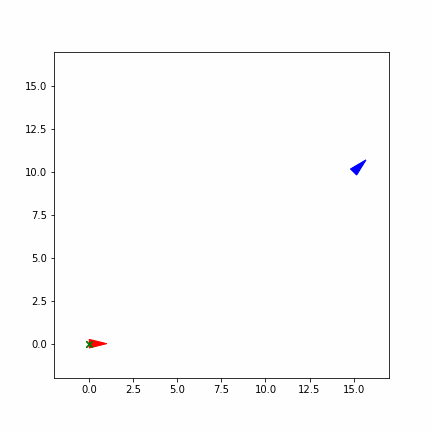

In [ ]:
from IPython.display import Image
Image(open('robot_animation.gif','rb').read())

### Based on 
https://github.com/MMehrez/MPC-and-MHE-implementation-in-MATLAB-using-Casadi